In [2]:
%matplotlib inline

# BrainHack Marseille 2023: "Surf(ac)ing fMRI" Project 
# -- Comparison between volume-based and surface-based GLM --
 ### Data from BRAINT project, task-03ArchiLocalizer. 
 ### Data anonymized by [bidsonym](https://peerherholz.github.io/BIDSonym) and preprocessed with [fmriprep](https://fmriprep.org/en/stable/) in volume and surface.
 ***

### Read the behavioural text file and build the DataFrame: "events" 

In [3]:
from IPython.display import display, HTML
import numpy as np
import pandas as pd
import chardet as cd


# path to sourcedata file

init_dir='/Users/jsein/Documents/Centre_IRMf/DATA/BIDS/BRAINT'
event_path=init_dir+'/sourcedata/sub-011/ses-02/sub-011_ses-02_task-03ArchiLocalizer_23_05_23_15_22.txt'
event_input = pd.read_csv(event_path,sep= '\t' , encoding='mac_roman')


In [4]:
# to determine the encoding, which is not standard here

with open(event_path, 'rb') as f:
    result = cd.detect(f.read())  # or readline if the file is large
    
print(result)


{'encoding': 'ISO-8859-1', 'confidence': 0.73, 'language': ''}


In [5]:
df_orig = pd.read_csv(event_path, encoding=result['encoding'], delimiter='\t')

print(df_orig)

     CONDITIONS  DURATIONS STIM_TEXT STIM_BITMAP STIM_WAV  RESPONSE_BUTTON  \
0             0         52       NaN        Noir      NaN                0   
1             8         27       NaN        Noir    calc1                0   
2             0          6       NaN        Noir      NaN                0   
3             8         27       NaN        Noir    calc2                0   
4             0         18       NaN        Noir      NaN                0   
..          ...        ...       ...         ...      ...              ...   
484           5         18       NaN        Noir      NaN                4   
485          10         27       NaN        Noir      ph9                0   
486           0         21       NaN        Noir      NaN                0   
487          10         27       NaN        Noir     ph10                0   
488           0         83       NaN        Noir      NaN                0   

     ONSETS_TRIGGERS  ONSETS_MS  REPONSE_1  JUSTE  INSTANT_REPO

In [6]:
# DataFrame for events: condition, onset, duration; time in seconds for nilearn
df_ev = pd.DataFrame()

# previous condition to check blocks
prev_cond = ''
# initialize duration and onset (in seconds)
duration = -1.0
onset = -1.0
onset2 = -1.0

# iterate over rows348156
for l in df_orig[['CONDITIONS', 'ONSETS_MS', 'ONSETS_TRIGGERS', 'DURATIONS']].iterrows():
    # get values
    _, (cur_cond, cur_ons2, cur_ons, cur_dur) = l
    # check if equality between current and past values for condition
    if cur_cond==prev_cond:
        duration += cur_dur
    else:
        # add row to DataFrame (conversion of onset and duration from trigger to seconds, 1 trigger = 80 ms; conversion of onset 2 from ms to s)
#        print(cur_cond, onset, duration)
        if not prev_cond=='':
            df_tmp = pd.DataFrame({'condition': prev_cond, 'onset2': onset2 / 1000.0, 'onset': onset * 0.08, 'duration': duration * 0.08}, [0])
            df_ev = pd.concat((df_ev, df_tmp), ignore_index=True)
        # move to next block
        prev_cond = cur_cond
        onset2 = cur_ons2
        onset = cur_ons
        duration = cur_dur
        
# check if onsets are similar in ms and trigger
df_ev

,condition,onset2,onset,duration
0,0,0.000,0.00,4.16
1,8,4.160,4.16,2.16
2,0,6.320,6.32,0.48
3,8,6.799,6.80,2.16
4,0,8.960,8.96,3.60
...,...,...,...,...
153,0,338.076,338.08,1.36
154,5,339.436,339.44,2.72
155,10,342.156,342.16,2.16
156,0,344.316,344.32,1.68


In [7]:
# check all conditions
print(np.unique(df_ev['condition']))

[ 0  1  2  3  4  5  6  7  8  9 10]


In [8]:
condition_ids = [
    "rest",      #"rest" will be condition 0
    "vertical checkerboard",     #"vertical checkerboard" will be condition 1
    "horizontal checkerboard",   # ...
    "left button press, visual instructions",
    "left button press, auditory instructions",
    "right button press, visual instructions",
    "right button press, auditory instructions",
    "mental computation, visual instructions",
    "mental computation, auditory instructions",
    "visual sentence",
    "auditory sentence",
]

trial_types = [condition_ids[i] for i in df_ev['condition']]

print(trial_types)

['rest', 'mental computation, auditory instructions', 'rest', 'mental computation, auditory instructions', 'rest', 'vertical checkerboard', 'rest', 'left button press, visual instructions', 'rest', 'auditory sentence', 'rest', 'right button press, visual instructions', 'rest', 'auditory sentence', 'rest', 'left button press, auditory instructions', 'rest', 'right button press, auditory instructions', 'rest', 'auditory sentence', 'rest', 'horizontal checkerboard', 'rest', 'mental computation, visual instructions', 'rest', 'visual sentence', 'rest', 'visual sentence', 'rest', 'mental computation, visual instructions', 'rest', 'mental computation, visual instructions', 'rest', 'visual sentence', 'rest', 'vertical checkerboard', 'rest', 'left button press, auditory instructions', 'rest', 'right button press, visual instructions', 'rest', 'right button press, auditory instructions', 'rest', 'visual sentence', 'rest', 'mental computation, visual instructions', 'rest', 'left button press, vis

In [9]:
events = pd.DataFrame(
    {
        "trial_type": trial_types,
        "onset": df_ev['onset'],
        "duration": df_ev['duration'],
    }
)

display(events)



,trial_type,onset,duration
0,rest,0.00,4.16
1,"mental computation, auditory instructions",4.16,2.16
2,rest,6.32,0.48
3,"mental computation, auditory instructions",6.80,2.16
4,rest,8.96,3.60
...,...,...,...
153,rest,338.08,1.36
154,"right button press, visual instructions",339.44,2.72
155,auditory sentence,342.16,2.16
156,rest,344.32,1.68


### Save the events to a tsv file

In [10]:
from pathlib import Path

local_dir='/Users/jsein/Documents/Centre_IRMf/DATA/BIDS/BRAINT'
outdir = Path(local_dir+'/derivatives/'+"results")
if not outdir.exists():
    outdir.mkdir()
tsvfile = outdir / "localizer_events.tsv"
events.to_csv(tsvfile, sep="\t", index=False)
print(f"The event information has been saved to {tsvfile}")

The event information has been saved to /Users/jsein/Documents/Centre_IRMf/DATA/BIDS/BRAINT/derivatives/results/localizer_events.tsv


### Visualize the events chronology

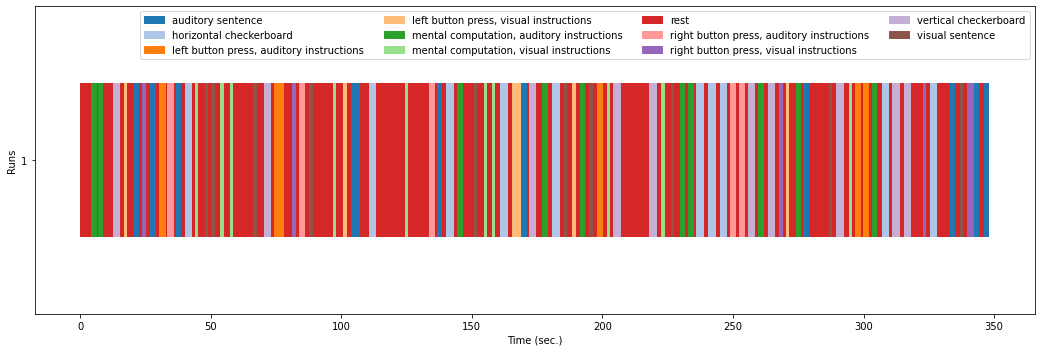

In [11]:
import matplotlib.pyplot as plt

from nilearn.plotting import plot_event

plot_event(events, figsize=(15, 5))
plt.show()

### Build the confounds Dataframe: "nuisance"

In [12]:
confounds_file=pd.read_csv(init_dir+'/derivatives/fmriprep/sub-011/ses-02/func/sub-011_ses-02_task-03ArchiLocalizer_desc-confounds_timeseries.tsv',sep= '\t')

motion6=confounds_file[["rot_x","rot_y","rot_z","trans_x",'trans_y','trans_z']]
motion24=confounds_file[["rot_x","rot_y","rot_z","trans_x","trans_y","trans_z","rot_x_derivative1","rot_y_derivative1","rot_z_derivative1",
                       "trans_x_derivative1","trans_y_derivative1","trans_z_derivative1","rot_x_power2","rot_y_power2","rot_z_power2",
                       "trans_x_power2",'trans_y_power2','trans_z_power2',"rot_x_derivative1_power2","rot_y_derivative1_power2","rot_z_derivative1_power2",
                       "trans_x_derivative1_power2","trans_y_derivative1_power2","trans_z_derivative1_power2"]]

acompcor = [] 
for i in range(0,12):
    #acompcor=acompcor.append(['w_comp_cor_' + i])
    acompcor.append("w_comp_cor_"+f"{i:02d}")
for i in range(0,12):
    #acompcor=acompcor.append(['w_comp_cor_' + i])
    acompcor.append("c_comp_cor_"+f"{i:02d}")

acompcor_reg=confounds_file[acompcor]

pd.options.mode.chained_assignment = None
motion24[np.isnan(motion24)] = 0
#display(motion24)
#display(acompcor_reg)

nuisance=result = pd.concat([motion24,acompcor_reg],axis=1)
display(nuisance)

,rot_x,rot_y,rot_z,trans_x,trans_y,trans_z,rot_x_derivative1,rot_y_derivative1,rot_z_derivative1,trans_x_derivative1,...,c_comp_cor_02,c_comp_cor_03,c_comp_cor_04,c_comp_cor_05,c_comp_cor_06,c_comp_cor_07,c_comp_cor_08,c_comp_cor_09,c_comp_cor_10,c_comp_cor_11
0,-0.001111,-0.001251,-0.001001,0.023798,-0.109870,-0.102884,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-0.000620,-0.000777,-0.000555,0.029922,-0.102383,0.089505,0.000491,0.000473,0.000446,0.006123,...,-0.080369,0.373134,-0.627848,0.048679,-0.005647,0.020522,-0.021214,0.001944,-0.052615,0.048079
2,-0.001273,-0.000698,-0.000617,0.030637,-0.033375,0.061950,-0.000653,0.000080,-0.000062,0.000715,...,-0.098083,0.181468,-0.270589,0.115828,-0.066043,0.010183,0.001836,0.026496,0.014788,-0.101681
3,-0.001115,-0.000601,-0.000492,0.020787,-0.055846,-0.032006,0.000158,0.000097,0.000125,-0.009850,...,0.058100,0.060400,-0.112250,-0.017181,-0.049301,-0.064356,0.033343,0.061144,-0.013985,0.001092
4,-0.000218,-0.000454,-0.000560,0.023378,-0.075993,0.086691,0.000897,0.000147,-0.000067,0.002591,...,0.028754,0.037421,-0.071570,0.089036,-0.010940,-0.109551,-0.020629,-0.008872,-0.066182,0.014525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312,0.002655,0.001759,-0.000187,-0.005849,0.152124,0.108372,0.000019,0.000015,-0.000053,-0.002585,...,0.000264,-0.043995,0.050347,-0.061726,0.013663,-0.025774,0.019046,0.035025,0.045271,0.086242
313,0.003351,0.002059,-0.000276,0.002168,0.102031,0.134814,0.000696,0.000300,-0.000089,0.008018,...,0.053951,-0.014889,0.025023,0.090086,0.018626,-0.046103,-0.008834,-0.007975,0.049392,-0.009172
314,0.003021,0.001860,-0.000185,-0.001621,0.151631,0.147693,-0.000330,-0.000199,0.000091,-0.003789,...,-0.078309,-0.000555,0.013468,-0.053736,-0.007962,-0.091323,-0.001460,0.003019,0.029679,0.007971
315,0.002705,0.001736,-0.000162,-0.006470,0.168322,0.116396,-0.000316,-0.000124,0.000023,-0.004849,...,-0.022628,-0.062872,0.042183,0.033351,-0.036721,-0.019280,0.019476,0.042516,0.114035,0.051780


### Implement the General Linear Model for single session fMRI data

In [13]:
from nilearn.glm.first_level import FirstLevelModel,make_first_level_design_matrix
import numpy as np
import json
import os
import nibabel as nib

json_file=init_dir+"/derivatives/fmriprep/sub-011/ses-02/func/sub-011_ses-02_task-03ArchiLocalizer_space-MNI152NLin2009cAsym_desc-preproc_bold.json"
fmri_data=init_dir+"/derivatives/fmriprep/sub-011/ses-02/func/sub-011_ses-02_task-03ArchiLocalizer_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"
mask_fmri_data=init_dir+"/derivatives/fmriprep/sub-011/ses-02/func/sub-011_ses-02_task-07BodyLocalizer_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz"

img = nib.load(fmri_data)


with open(json_file, 'r') as f:
    t_r = json.load(f)['RepetitionTime']

fmri_glm = FirstLevelModel(
    t_r=t_r,
    noise_model="ar1",
    smoothing_fwhm=4,
    standardize=False,
    mask_img=mask_fmri_data,
    hrf_model="spm",
    drift_model="cosine",
    high_pass=0.01,
)


n_scans = img.shape[3]  # the acquisition comprises 128 scans
frame_times = np.arange(n_scans) * t_r  # here are the corresponding frame times

### display the reference bold image

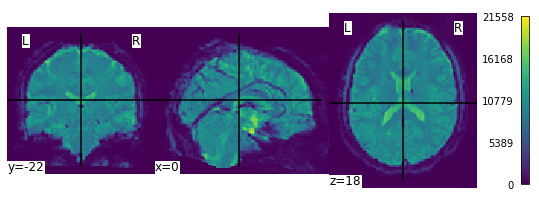

In [14]:
from nilearn.plotting import plot_anat, plot_img, plot_stat_map

ref_fmri_data=init_dir+"/derivatives/fmriprep/sub-011/ses-02/func/sub-011_ses-02_task-03ArchiLocalizer_space-MNI152NLin2009cAsym_boldref.nii.gz"

plot_img(ref_fmri_data, colorbar=True, cbar_tick_format="%i")


### Fit the data with the GLM

In [15]:
fmri_glm = fmri_glm.fit(fmri_data, events,nuisance)

### Look at the desing matrix

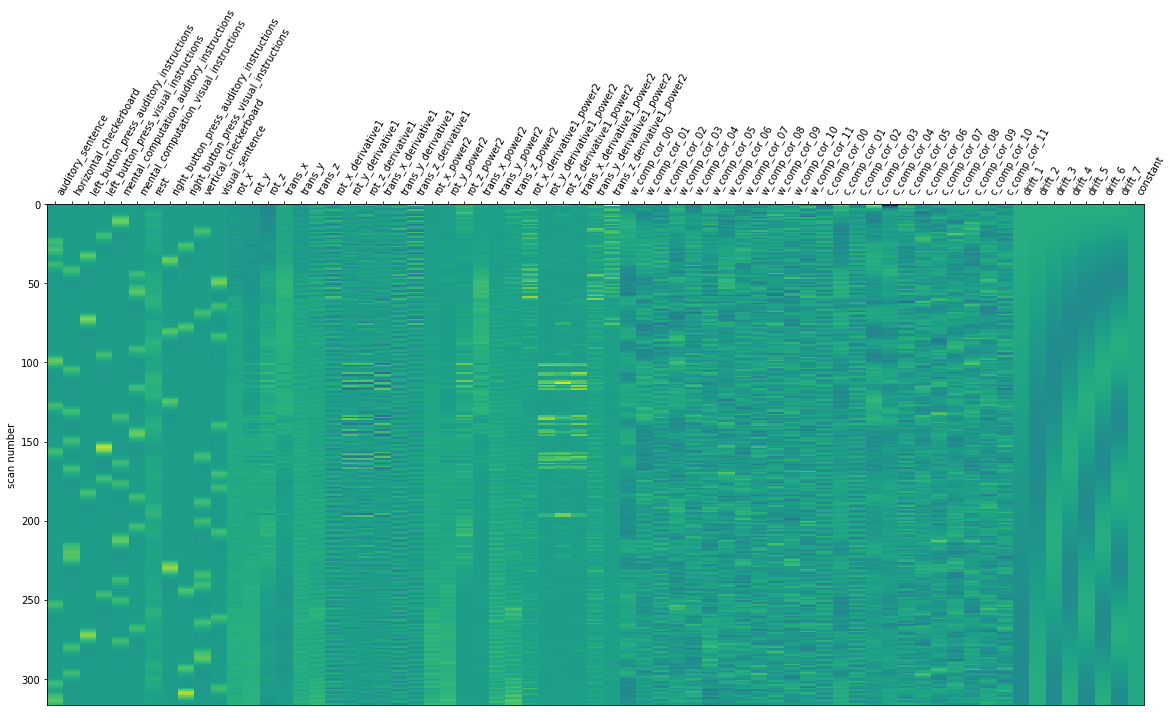

In [16]:
import matplotlib.pyplot as plt

from nilearn.plotting import plot_design_matrix

design_matrix = fmri_glm.design_matrices_[0]
plot_design_matrix(design_matrix)
#plot_design_matrix(X1)

plt.show()

In [17]:
design_matrix.shape[1]

67

In [18]:
### Save the design matrix as an image

In [19]:
import os

outdir = Path(local_dir+'/derivatives/'+"results")
if not os.path.exists(outdir):
    os.mkdir(outdir)

from os.path import join

plot_design_matrix(
    design_matrix, output_file=join(outdir, "design_matrix_new.png")
)


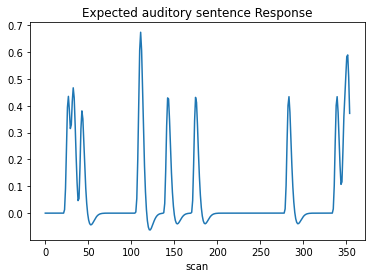

In [20]:
plt.plot(design_matrix["auditory_sentence"])
plt.xlabel("scan")
plt.title("Expected auditory sentence Response")
plt.show()

### Prepare the contrasts: exemple with "auditory Sentence" - "horizontal checkerboard"
Watchout for nilearn reordering of conditions columns based on alphabetical order !!!

<AxesSubplot:label='conditions'>

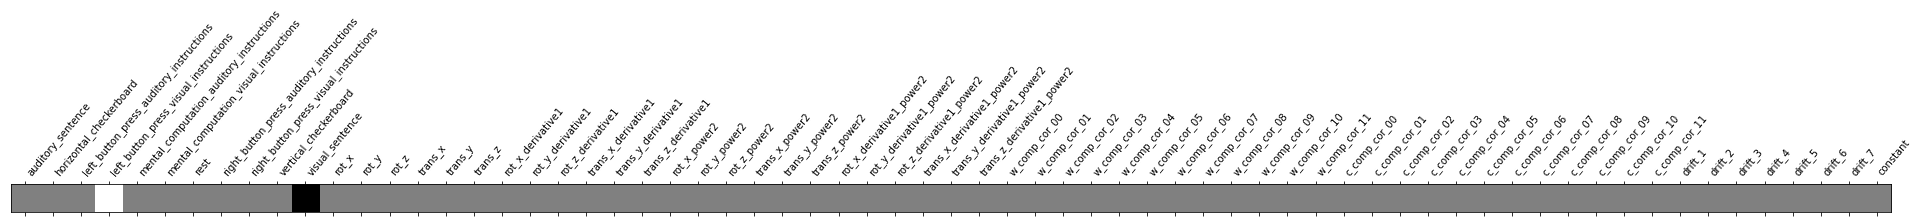

In [21]:
from nilearn.plotting import plot_contrast_matrix

conditions = {"rest": np.zeros(design_matrix.shape[1]),
              "vertical checkerboard": np.zeros(design_matrix.shape[1]),
              "horizontal checkerboard": np.zeros(design_matrix.shape[1]),
              "left button press, auditory instructions": np.zeros(design_matrix.shape[1]),
              "left button press, visual instructions": np.zeros(design_matrix.shape[1]),
              "right button press, visual instructions": np.zeros(design_matrix.shape[1]),
              "right button press, auditory instructions": np.zeros(design_matrix.shape[1]),
              "mental computation, auditory instructions": np.zeros(design_matrix.shape[1]),
              "mental computation, visual instructions": np.zeros(design_matrix.shape[1]),
              "visual sentence": np.zeros(design_matrix.shape[1]),
              "auditory sentence": np.zeros(design_matrix.shape[1]),
             }

conditions["auditory sentence"][0] = 1
conditions["horizontal checkerboard"][1] = 1
conditions["left button press, auditory instructions"][2] = 1
conditions["left button press, visual instructions"][3] = 1
conditions["mental computation, auditory instructions"][4] = 1
conditions["mental computation, visual instructions"][5] = 1
conditions["rest"][6] = 1
conditions["right button press, auditory instructions"][7] = 1
conditions["right button press, visual instructions"][8] = 1
conditions["vertical checkerboard"][9] = 1
conditions["visual sentence"][10] = 1


#auditory_minus_visual = conditions["auditory sentence"] - conditions["vertical checkerboard"]

contrast1 = conditions["left button press, visual instructions"] \
- conditions["visual sentence"] \


plot_contrast_matrix(contrast1 , design_matrix=design_matrix)

### Compute effect size

In [22]:
eff_map = fmri_glm.compute_contrast(
    contrast1, output_type="effect_size"
)

### Compute z-score

In [23]:
z_map = fmri_glm.compute_contrast(contrast1, output_type="z_score")

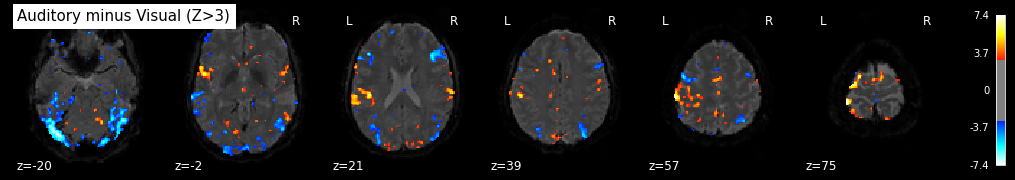

In [24]:
plot_stat_map(
    z_map,
    bg_img=ref_fmri_data,
    threshold=3.0,
    display_mode="z",
    cut_coords=6,
    black_bg=True,
    title="Auditory minus Visual (Z>3)",
)
plt.show()

Uncorrected p<0.001 threshold: 3.291


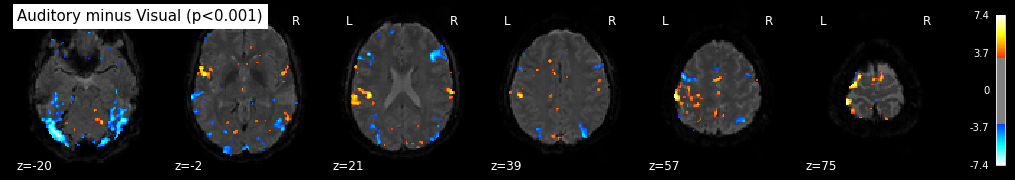

In [25]:
from nilearn.glm import threshold_stats_img

_, threshold = threshold_stats_img(z_map, alpha=0.001, height_control="fpr")
print(f"Uncorrected p<0.001 threshold: {threshold:.3f}")
plot_stat_map(
    z_map,
    bg_img=ref_fmri_data,
    threshold=threshold,
    display_mode="z",
    cut_coords=6,
    black_bg=True,
    title="Auditory minus Visual (p<0.001)",
)
plt.show()

Bonferroni-corrected, p<0.05 threshold: 5.212


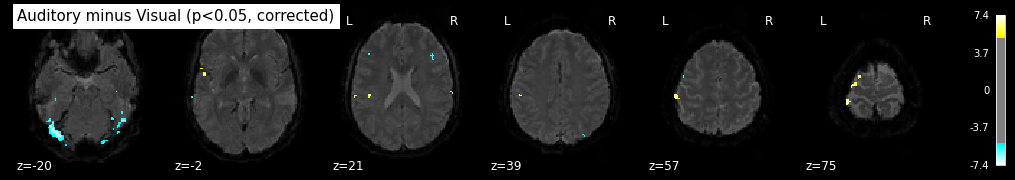

In [26]:
_, threshold = threshold_stats_img(
    z_map, alpha=0.05, height_control="bonferroni"
)
print(f"Bonferroni-corrected, p<0.05 threshold: {threshold:.3f}")
plot_stat_map(
    z_map,
    bg_img=ref_fmri_data,
    threshold=threshold,
    display_mode="z",
    cut_coords=6,
    black_bg=True,
    title="Auditory minus Visual (p<0.05, corrected)",
)
plt.show()

False Discovery rate = 0.05 threshold: 2.870


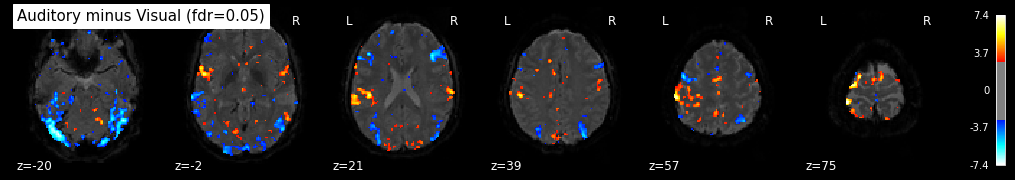

In [27]:
_, threshold = threshold_stats_img(z_map, alpha=0.05, height_control="fdr")
print(f"False Discovery rate = 0.05 threshold: {threshold:.3f}")
plot_stat_map(
    z_map,
    bg_img=ref_fmri_data,
    threshold=threshold,
    display_mode="z",
    cut_coords=6,
    black_bg=True,
    title="Auditory minus Visual (fdr=0.05)",
)
plt.show()

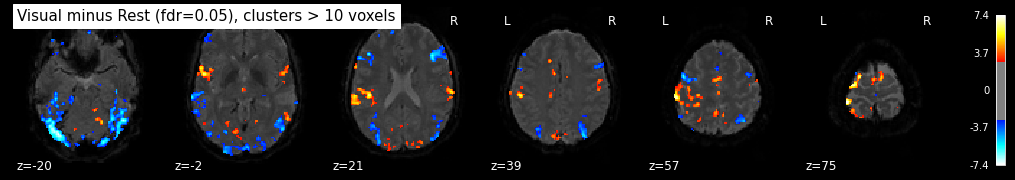

In [28]:
clean_map, threshold = threshold_stats_img(
    z_map, alpha=0.05, height_control="fdr", cluster_threshold=10
)
plot_stat_map(
    clean_map,
    bg_img=ref_fmri_data,
    threshold=threshold,
    display_mode="z",
    cut_coords=6,
    black_bg=True,
    title="Visual minus Rest (fdr=0.05), clusters > 10 voxels",
)
plt.show()

In [29]:
from nilearn.reporting import get_clusters_table

table = get_clusters_table(
    z_map, stat_threshold=threshold, cluster_threshold=20
)
table

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3)
0,1,-40.5,-34.5,75.5,7.335226,25840
1,1a,-32.5,-12.5,75.5,6.964211,
2,1b,-48.5,-38.5,65.5,6.864295,
3,1c,-58.5,-28.5,57.5,6.833487,
4,2,-4.5,-2.5,79.5,6.210175,4192
...,...,...,...,...,...,...
77,33,11.5,-92.5,25.5,3.954867,520
78,33a,3.5,-90.5,19.5,3.795237,
79,34,19.5,-54.5,61.5,3.742734,240
80,34a,23.5,-58.5,69.5,3.686833,


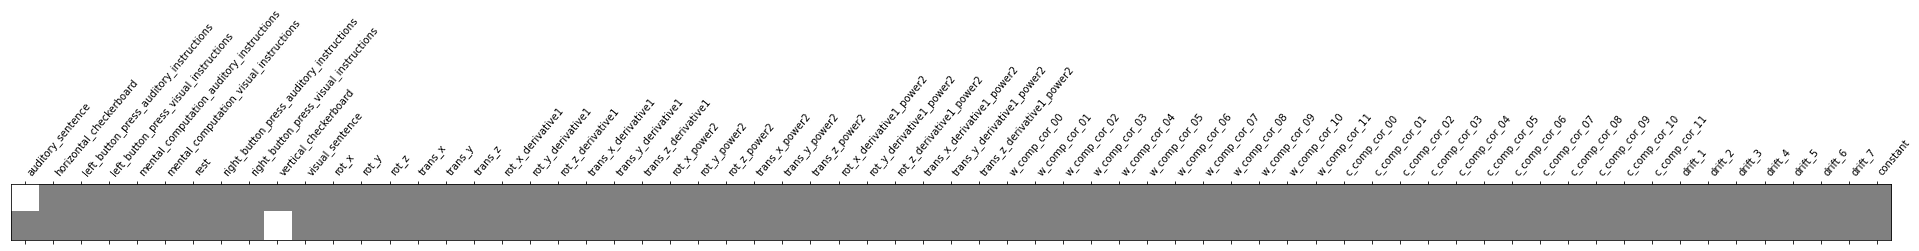

In [30]:
effects_of_interest = np.vstack((conditions["auditory sentence"], conditions["vertical checkerboard"]))
plot_contrast_matrix(effects_of_interest, design_matrix)
plt.show()

z_map = fmri_glm.compute_contrast(effects_of_interest, output_type="z_score")

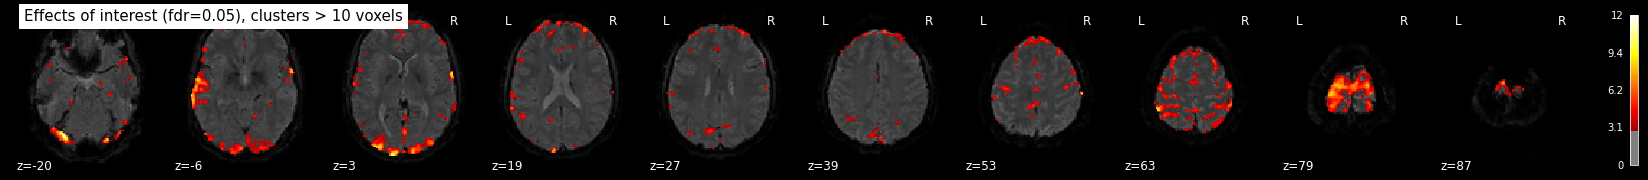

In [31]:
clean_map, threshold = threshold_stats_img(
    z_map, alpha=0.05, height_control="fdr", cluster_threshold=10
)
plot_stat_map(
    clean_map,
    bg_img=ref_fmri_data,
    threshold=threshold,
    display_mode="z",
    cut_coords=10,
    black_bg=True,
    title="Effects of interest (fdr=0.05), clusters > 10 voxels",
)
plt.show()